In [1]:
import gzip
import json
import pickle
import os
from loguru import logger

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from haversine import haversine
import geopandas as gpd

import numpy as np
import pandas as pd

from ppgmne_prf.config.paths import PATH_DATA_SOLVER_DETAILS, PATH_DATA_SOLVER_RESULTS, PATH_DATA_IBGE_UF, PATH_DATA_CACHE
from ppgmne_prf.utils import get_distance_matrix
from ppgmne_prf.load_data import load_data
from ppgmne_prf.preprocess import preprocess_accidents, preprocess, preprocess_stations
from ppgmne_prf.utils import clean_string

pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.set_option('display.float_format', lambda x: '%.4f' % x)
plt.rcParams['figure.figsize'] = [15, 8]

sns.set_palette('deep')
PALETTE = sns.color_palette()

MAP_COLOR = '#d1cab2'
# SHAPE = gpd.read_file(PATH_DATA_IBGE_UF / 'PR_Municipios_2019.shp')
SHAPE = gpd.read_file(PATH_DATA_IBGE_UF / 'PR_RG_Imediatas_2022.shp')

In [2]:
SHAPE.head()

,CD_RGI,NM_RGI,SIGLA_UF,AREA_KM2,geometry
0,410001,Curitiba,PR,16577.7180,"POLYGON ((-49.52977 -24.71558, -49.53044 -24.7..."
1,410002,Paranaguá,PR,6055.3360,"MULTIPOLYGON (((-48.64353 -25.13095, -48.64355..."
2,410003,União da Vitória,PR,7313.5850,"POLYGON ((-50.89745 -26.05719, -50.89698 -26.0..."
3,410004,Guarapuava,PR,13853.3830,"POLYGON ((-51.13312 -25.50081, -51.13610 -25.5..."
4,410005,Pitanga,PR,5438.1740,"POLYGON ((-52.04754 -24.56672, -52.04780 -24.5..."


In [3]:
# Funções úteis:

def get_df_results(df_results, p=None, q=None):
    if p is None:
        df_out = df_results[(df_results['q'] == q)].copy()
    if q is None:
        df_out = df_results[(df_results['p'] == p)].copy()
    df_out['obj_function_abs_diff'] = abs(df_out['obj_function'].diff().fillna(0))
    df_out['obj_function_abs_pct_change'] = abs(df_out['obj_function'].pct_change().fillna(0))*100
    df_out['obj_function_abs_pct_change'] = np.where(
        df_out['obj_function_abs_pct_change'] == 0, 
        np.nan, 
        df_out['obj_function_abs_pct_change']
    )
    return df_out

def get_solution_details(q, p):
    model_name = f'model_p{p}_q{q}_details'
    with gzip.open(PATH_DATA_SOLVER_DETAILS / f"{model_name}.gz", "rb") as f:
            df_out = pickle.load(f)
    return df_out


def preproccess_muns(df_muns):
    cols = ['municipio', 'microrregiao', 'mesorregiao', 'regiao_imediata']
    cols_en = ['municipality', 'microregion', 'mesoregion', 'immediate_region', 'mun_name_orig']
    df_out = df_muns[cols].copy()
    df_out['mun_name_orig'] = df_out['municipio']

    for col in cols:
        df_out = clean_string(df=df_out, target=col, mode='upper')

    df_out.columns = cols_en
    return df_out


def get_all_results():
    output_dict = None

    for file in os.listdir(PATH_DATA_SOLVER_RESULTS):
        if file.split(".")[-1] == "json":
            with open(PATH_DATA_SOLVER_RESULTS / file) as file:
                dict_result = json.load(file)
            if output_dict is None:
                output_dict = dict_result
                for key in dict_result:
                    output_dict[key] = [dict_result[key]]
            else:
                for key in dict_result:
                    output_dict[key].append(dict_result[key])

    df_out = pd.DataFrame(output_dict)
    df_out = df_out.sort_values(['p', 'q']).reset_index(drop=True)
    return df_out


def plot_fo(
    df_plot,
    x_param,
    xtick_min=0,
    xtick_max=80,
    xtick_multiple=2,
    p2_ytick_max=15,
    pct_cutover=2.5,
    x_cutover=None,
    xlabel='Número de UOPs a serem instaladas (p)',
    p1_ylabel='Função objetivo (Z)',
    p2_ylabel='Decrescimento Percentual de Z',
    fontsize=14,
    figsize=(15,8),
    invert_x=False,
    palette=PALETTE,
    arrow_txt="p = 36",
    arrow_xy=(35.7, 2.25),
    arrow_txt_xy=(20, 1),
    only_feasible=False):

    if only_feasible:
        df_plot = df_plot[df_plot['is_feasible'] == True]

    plt.subplots(figsize=figsize)

    p1 = sns.lineplot(df_plot, x=x_param, y='obj_function', color=palette[0])
    sns.scatterplot(df_plot, x=x_param, y='obj_function', color=palette[0])
    p1.set_xlabel(xlabel,fontsize=fontsize)
    p1.set_ylabel(p1_ylabel, color=palette[0], fontsize=fontsize)

    p2 = p1.twinx()
    sns.lineplot(df_plot, x=x_param, y='obj_function_abs_pct_change', color=palette[1])
    sns.scatterplot(df_plot, x=x_param, y='obj_function_abs_pct_change', color=palette[1])
    # p2.set_yticks(range(0, p2_ytick_max+1, 1))
    p2.set_yticks(np.arange(0, p2_ytick_max+0.5, 0.5))
    p2.set_ylabel(p2_ylabel, color=palette[1], fontsize=fontsize)

    if pct_cutover is not None:
        plt.axhline(y=pct_cutover, color=palette[7], linestyle='--')

    if x_cutover is not None:
        plt.axvline(x=x_cutover, color=palette[7], linestyle='--')

    if invert_x:
        plt.gca().invert_xaxis()

    if arrow_txt is not None:
        plt.annotate(arrow_txt, xy=arrow_xy, xytext=arrow_txt_xy, arrowprops={'arrowstyle': "->"})

    plt.xticks(range(xtick_min, xtick_max+1, xtick_multiple))
    plt.savefig('foo.png')   
    plt.show()


def get_uops_by_sol(df_feasibles):
    dict_sols = {'p': [], 'q': [], 'name': []}

    for row in df_feasibles.itertuples():
        df_sol = get_solution_details(p=row.p, q=row.q)
        uops = list(df_sol[df_sol['is_median'] == 1]['name'])
        dict_sols['p'] = dict_sols['p'] + [row.p]*len(uops)
        dict_sols['q'] = dict_sols['q'] + [row.q]*len(uops)
        dict_sols['name'] = dict_sols['name'] + uops

    return pd.DataFrame(dict_sols)


def agg_uops(df, p=None, q=None):
    if p is not None:
        df = df[df['p'] == p].copy()
    if q is not None:
        df = df[df['q'] == q].copy()
    df_out = df.groupby('name').agg(n=('name', 'count')).reset_index()
    return df_out


def merge_uops(df, df_agg):
    df_out = df.merge(df_agg, how='left', on='name')
    df_out['n'] = df_out['n'].fillna(0)
    df_out = df_out.sort_values(by='n', ascending=False).reset_index(drop=True)
    return df_out


def agg_and_merge_uops(df_uops_base, df_uops_by_sols, n_total, q=None, p=None):

    df_agg = agg_uops(df_uops_by_sols, p=p, q=q)
    df_out = merge_uops(df_uops_base, df_agg)
    df_out['pct_solutions'] = df_out['n'] / n_total * 100

    # Cria colunas para gerar tabelas latex
    df_out['UOP'] = df_out['name']
    df_out['Município'] = df_out['mun_name_orig']
    df_out['Atual'] = df_out['is_uop'].apply(lambda x: "Sim" if x == True else "Não")
    df_out['Soluções'] = df_out['n'].astype(int).astype(str) + " (" + df_out['pct_solutions'].round(0).astype(int).astype(str) + "%)"

    return df_out


def plot_uops_by_sol(df_plot, range_p, figsize=(15,8), grid=False):
    plt.subplots(figsize=figsize)

    sns.scatterplot(df_plot, x='p', y='name', s=180)
    plt.xticks(range_p)
    plt.xlabel("Número de UOPs a serem instaladas (p)", fontsize=14)
    plt.ylabel("")

    if grid:
        plt.grid()
        
    plt.savefig('foo.png')   
    plt.show()


def get_realoc_solution(q, p, uop_alocada, uop_proposta, last_fo_dif=None):
    df_sol = get_solution_details(q, p)
    fo_orig = df_sol['obj_function'].sum()


    uop_proposta_lat = df_sol[df_sol['name'] == uop_proposta]['latitude'].max()
    uop_proposta_lon = df_sol[df_sol['name'] == uop_proposta]['longitude'].max()
    df_sol['is_median'] = np.where(df_sol['name'].isin([uop_alocada, uop_proposta]), ~df_sol['is_median'], df_sol['is_median'])
    df_sol['median_name'] = np.where(df_sol['median_name'] == uop_alocada, uop_proposta, df_sol['median_name'])
    df_sol['median_lat'] = np.where(df_sol['median_name'] == uop_proposta, uop_proposta_lat, df_sol['median_lat'])
    df_sol['median_lon'] = np.where(df_sol['median_name'] == uop_proposta, uop_proposta_lon, df_sol['median_lon'])
    df_sol['distance_q_to_m'] = df_sol.apply(lambda x: haversine(point1=(x['latitude'], x['longitude']), point2=(x['median_lat'], x['median_lon'])), axis=1)
    df_sol['obj_function'] = df_sol['distance_q_to_m'] * df_sol['n_accidents']

    fo_new = df_sol['obj_function'].sum()
    if last_fo_dif is not None:
        fo_orig = fo_orig + last_fo_dif
        fo_new = fo_new + last_fo_dif

    df_dist = df_sol[df_sol['name'].isin([uop_alocada, uop_proposta])]
    dist_matrix = get_distance_matrix(
        df_dist["latitude"], df_dist["longitude"], df_dist["latitude"], df_dist["longitude"]
    )
    dist = dist_matrix.max()

    logger.info(f"FO inicial: {fo_orig}")
    logger.info(f"FO final: {fo_new}")
    logger.info(f"Variação da FO: {fo_new - fo_orig} | {round((fo_new - fo_orig)/fo_orig*100,2)}%")
    logger.info(f"Distância entre {uop_alocada} e {uop_proposta}: {round(dist,2)}km")

    return df_sol


def plot_solutions_map(q, p, x='longitude', y='latitude', xlab="Longitude", ylab="Latitude", figsize=(15,8), fontsize=14):
    df_sol = get_solution_details(q=q, p=p)

    df_accidents = df_sol.dropna()
    df_accidents['Quadrante'] = "Acidente"

    df_uops = df_sol[df_sol['is_median'] == True].copy()
    df_uops['Quadrante'] = "UOP"

    cols = ["name", "municipality", "n_accidents", "latitude", "longitude", "median_lat", "median_lon", "Quadrante"]
    df = pd.concat([df_accidents[cols], df_uops[cols]], ignore_index=True)
    df.rename(columns={'n_accidents': "Qtd. acidentes"}, inplace=True)

    fig, ax = plt.subplots(figsize=figsize)
    SHAPE.plot(ax = ax, color = MAP_COLOR)
    p = sns.scatterplot(data=df, x=x, y=y, hue="Quadrante")
    p.set_xlabel(xlab, fontsize=fontsize)
    p.set_ylabel(ylab, fontsize=fontsize)

    legend_name="" 
    plt.legend(title=legend_name, title_fontsize=11, labelspacing=1.2, borderpad=1.1)

    for row in df.itertuples():
        lat0 = row.latitude
        lat1 = row.median_lat
        lon0 = row.longitude
        lon1 = row.median_lon
        x = (lon0, lon1)
        y = (lat0, lat1)
        plt.plot(x, y, color=PALETTE[1], linewidth='0.8')

    plt.savefig('foo.png')   
    plt.show()


In [4]:
# Carrega os dados pré-modelagem:
df_accidents, dict_stations = load_data()
df_quadrants = preprocess(df_accidents, dict_stations)

2023-09-09 14:21:31.480 | INFO     | ppgmne_prf.load_data:load_data:16 - Load data - Início do carregamento os dados de entrada.
2023-09-09 14:21:31.482 | INFO     | ppgmne_prf.load_data:load_data:18 - Load data (accidents) - Carregando os dados históricos dos acidentes.
2023-09-09 14:21:31.484 | WARNING  | ppgmne_prf.load_data:__load_accidents:44 - Load data (accidents) - Dados carregados da cache.
2023-09-09 14:21:31.650 | INFO     | ppgmne_prf.load_data:load_data:21 - Load data (stations) - Carregando as coordenadas das UOPs e delegacias.
2023-09-09 14:21:31.651 | WARNING  | ppgmne_prf.load_data:__load_stations:132 - Load data (stations) - Dados carregados da cache.
2023-09-09 14:21:31.652 | INFO     | ppgmne_prf.load_data:load_data:26 - Load data - Fim do carregamento os dados de entrada.
2023-09-09 14:21:31.652 | INFO     | ppgmne_prf.preprocess:preprocess:37 - Pre-process - Início do pré-processamento dos dados de entrada.
2023-09-09 14:21:31.652 | INFO     | ppgmne_prf.preproces

In [5]:
# Carrega os resultados:
df_all_results = get_all_results()

# Soluções livres
df_results_p = get_df_results(df_all_results, p=39)
df_results_p['obj_function_abs_pct_change'] = df_results_p['obj_function_abs_pct_change'].fillna(0)
df_results_p

,name,p,q,solver,is_feasible,is_optimal,obj_function,obj_function_abs_diff,obj_function_abs_pct_change
764,model_p39_q0_results,39,0,gurobi,True,True,378908.1202,0.0000,0.0000
765,model_p39_q1_results,39,1,gurobi,True,True,378908.1202,0.0000,0.0000
766,model_p39_q2_results,39,2,gurobi,True,True,378908.1202,0.0000,0.0000
767,model_p39_q3_results,39,3,gurobi,True,True,378908.1202,0.0000,0.0000
768,model_p39_q4_results,39,4,gurobi,True,True,378908.1202,0.0000,0.0000
769,model_p39_q5_results,39,5,gurobi,True,True,378908.1202,0.0000,0.0000
770,model_p39_q6_results,39,6,gurobi,True,True,378996.9816,88.8614,0.0235
771,model_p39_q7_results,39,7,gurobi,True,True,379130.3858,133.4043,0.0352
772,model_p39_q8_results,39,8,gurobi,True,True,379324.7975,194.4117,0.0513
773,model_p39_q9_results,39,9,gurobi,True,True,379677.8692,353.0717,0.0931


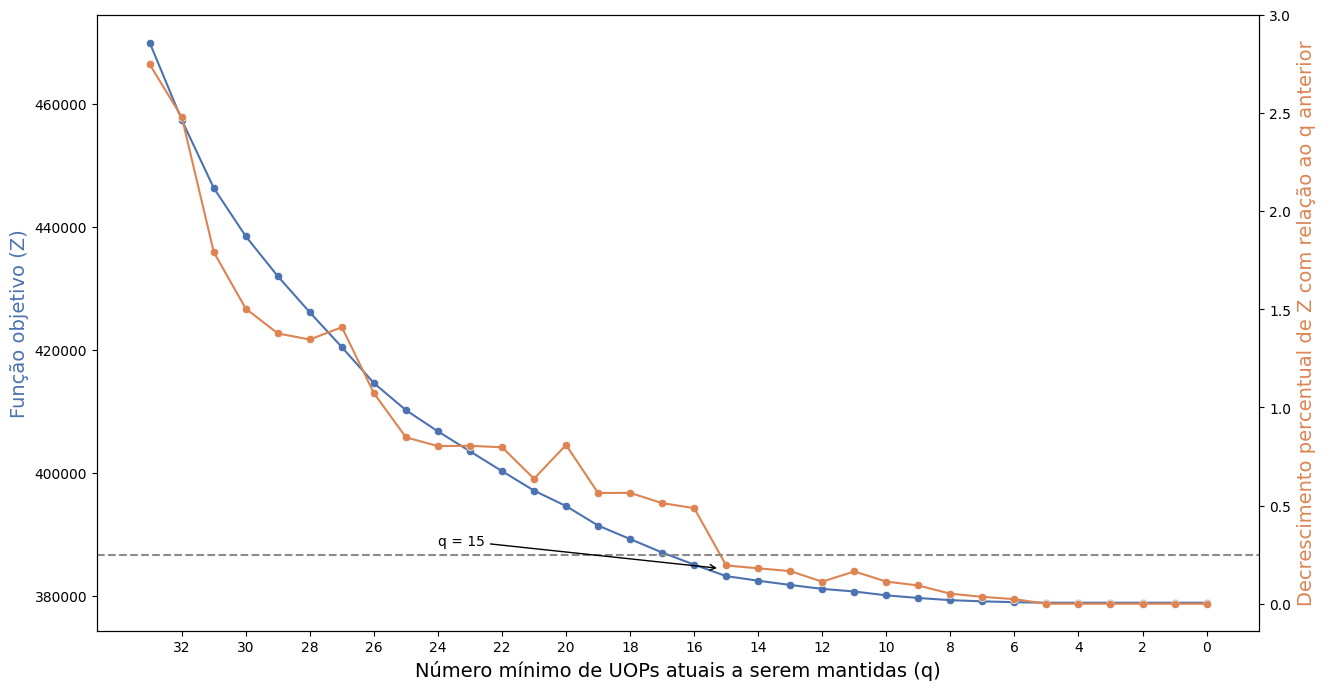

In [6]:
plot_fo(
    df_results_p, 
    x_param="q", 
    xtick_min=0, 
    xtick_max=33, 
    invert_x=True, 
    pct_cutover=0.25, 
    p2_ytick_max=3, 
    xlabel="Número mínimo de UOPs atuais a serem mantidas (q)",
    p2_ylabel = "Decrescimento percentual de Z com relação ao q anterior",
    arrow_txt="q = 15",
    arrow_xy=(15.2, 0.18),
    arrow_txt_xy=(24, 0.3),)

In [7]:
df_sol_p39_q15 = get_solution_details(p=39, q=15)
df_sol_p39_q0 = get_solution_details(p=39, q=0)

def calculate_dif_fo(df_irrestrita, df_restrita):
    fo_irrestrita = df_irrestrita['obj_function'].sum()
    fo_restrita = df_restrita['obj_function'].sum()
    pct_dif = (fo_restrita - fo_irrestrita)/fo_irrestrita*100

    logger.info(f"FO irrestrita: {fo_irrestrita}")
    logger.info(f"FO irrestrita: {fo_restrita}")
    logger.info(f"Variação: {round(pct_dif,2)}%")

In [8]:
calculate_dif_fo(df_irrestrita=df_sol_p39_q0, df_restrita=df_sol_p39_q15)

2023-09-09 14:21:48.576 | INFO     | __main__:calculate_dif_fo:9 - FO irrestrita: 378908.1201697493
2023-09-09 14:21:48.577 | INFO     | __main__:calculate_dif_fo:10 - FO irrestrita: 383230.178389068
2023-09-09 14:21:48.577 | INFO     | __main__:calculate_dif_fo:11 - Variação: 1.14%


In [9]:
df_restrita = df_sol_p39_q15[df_sol_p39_q15['is_median'] == True].sort_values(by='is_uop', ascending=False).reset_index(drop=True)
df_restrita

,latitude,longitude,municipality,name,n_accidents,n_acc_holiday,n_acc_weekend,n_injuried,n_dead,cluster,dist_max,is_uop,is_only_uop,is_median,median_name,distance_q_to_m,obj_function,median_lat,median_lon
0,-23.6000,-51.4000,APUCARANA,UOP03-DEL07-PR,273.0000,8.0000,84.0000,73.0000,8.0000,4,120.0000,True,False,True,UOP03-DEL07-PR,0.0000,0.0000,-23.6000,-51.4000
1,-25.4000,-51.3000,GUARAPUAVA,UOP01-DEL08-PR,75.0000,0.0000,21.0000,18.0000,12.0000,2,180.0000,True,False,True,UOP01-DEL08-PR,0.0000,0.0000,-25.4000,-51.3000
2,-24.6000,-50.6000,TIBAGI,UOP02-DEL03-PR,31.0000,2.0000,5.0000,6.0000,1.0000,1,180.0000,True,False,True,UOP02-DEL03-PR,0.0000,0.0000,-24.6000,-50.6000
3,-25.9000,-50.4000,SAO MATEUS DO SUL,UOP04-DEL02-PR,149.0000,5.0000,54.0000,37.0000,11.0000,3,120.0000,True,False,True,UOP04-DEL02-PR,0.0000,0.0000,-25.9000,-50.4000
4,-26.3000,-51.2000,PORTO VITORIA,UOP03-DEL02-PR,36.0000,4.0000,12.0000,9.0000,7.0000,1,180.0000,True,False,True,UOP03-DEL02-PR,0.0000,0.0000,-26.3000,-51.2000
5,-25.7000,-53.8000,PLANALTO,UOP02-DEL02-PR,73.0000,0.0000,27.0000,19.0000,2.0000,2,180.0000,True,False,True,UOP02-DEL02-PR,0.0000,0.0000,-25.7000,-53.8000
6,-26.2000,-52.7000,PATO BRANCO,UOP01-DEL02-PR,221.0000,10.0000,60.0000,41.0000,6.0000,3,120.0000,True,False,True,UOP01-DEL02-PR,0.0000,0.0000,-26.2000,-52.7000
7,-23.1000,-52.4000,PARANAVAI,UOP02-DEL09-PR,107.0000,3.0000,42.0000,30.0000,9.0000,2,180.0000,True,False,True,UOP02-DEL09-PR,0.0000,0.0000,-23.1000,-52.4000
8,-25.6000,-48.6000,PARANAGUA,UOP05-DEL01-PR,463.0000,22.0000,151.0000,122.0000,25.0000,5,120.0000,True,False,True,UOP05-DEL01-PR,0.0000,0.0000,-25.6000,-48.6000
9,-24.6000,-54.0000,MARECHAL CANDIDO RONDON,UOP02-DEL06-PR,143.0000,3.0000,42.0000,42.0000,10.0000,3,120.0000,True,False,True,UOP02-DEL06-PR,0.0000,0.0000,-24.6000,-54.0000


In [10]:
df_livre = df_sol_p39_q0[df_sol_p39_q0['is_median'] == True].sort_values(by='is_uop', ascending=False).reset_index(drop=True)
df_livre

,latitude,longitude,municipality,name,n_accidents,n_acc_holiday,n_acc_weekend,n_injuried,n_dead,cluster,dist_max,is_uop,is_only_uop,is_median,median_name,distance_q_to_m,obj_function,median_lat,median_lon
0,-25.5000,-49.7000,BALSA NOVA,UOP06-DEL01-PR,189.0000,10.0000,63.0000,42.0000,17.0000,3,120.0000,True,False,True,UOP06-DEL01-PR,0.0000,0.0000,-25.5000,-49.7000
1,-25.9000,-49.0000,GUARATUBA,UOP04-DEL01-PR,269.0000,11.0000,85.0000,48.0000,9.0000,4,120.0000,True,False,True,UOP04-DEL01-PR,0.0000,0.0000,-25.9000,-49.0000
2,-25.6000,-48.6000,PARANAGUA,UOP05-DEL01-PR,463.0000,22.0000,151.0000,122.0000,25.0000,5,120.0000,True,False,True,UOP05-DEL01-PR,0.0000,0.0000,-25.6000,-48.6000
3,-23.1000,-52.4000,PARANAVAI,UOP02-DEL09-PR,107.0000,3.0000,42.0000,30.0000,9.0000,2,180.0000,True,False,True,UOP02-DEL09-PR,0.0000,0.0000,-23.1000,-52.4000
4,-26.2000,-52.7000,PATO BRANCO,UOP01-DEL02-PR,221.0000,10.0000,60.0000,41.0000,6.0000,3,120.0000,True,False,True,UOP01-DEL02-PR,0.0000,0.0000,-26.2000,-52.7000
5,-23.6000,-51.5000,APUCARANA,APUCARANA 01,254.0000,7.0000,66.0000,68.0000,15.0000,4,120.0000,False,False,True,APUCARANA 01,0.0000,0.0000,-23.6000,-51.5000
6,-25.1000,-50.2000,PONTA GROSSA,PONTA GROSSA 06,412.0000,14.0000,151.0000,105.0000,33.0000,5,120.0000,False,False,True,PONTA GROSSA 06,0.0000,0.0000,-25.1000,-50.2000
7,-23.4000,-51.9000,MARINGA,MARINGA 02,1276.0000,35.0000,373.0000,271.0000,28.0000,7,60.0000,False,False,True,MARINGA 02,0.0000,0.0000,-23.4000,-51.9000
8,-25.3000,-54.1000,MEDIANEIRA,MEDIANEIRA 01,208.0000,8.0000,98.0000,46.0000,15.0000,3,120.0000,False,False,True,MEDIANEIRA 01,0.0000,0.0000,-25.3000,-54.1000
9,-24.0000,-51.1000,ORTIGUEIRA,ORTIGUEIRA 08,159.0000,7.0000,44.0000,35.0000,10.0000,3,120.0000,False,False,True,ORTIGUEIRA 08,0.0000,0.0000,-24.0000,-51.1000


In [11]:
uops_livre = df_livre[df_livre['is_median'] == True]['name']
df_uops_livre = df_quadrants[df_quadrants['name'].isin(uops_livre)].copy()

uops_restrita = df_restrita[df_restrita['is_median'] == True]['name']
df_uops_restrita = df_quadrants[df_quadrants['name'].isin(uops_restrita)].copy()

In [12]:
dist_matrix = get_distance_matrix(
    lat_rows=df_uops_livre['latitude'],
    lon_rows=df_uops_livre['longitude'],
    lat_cols=df_uops_restrita['latitude'],
    lon_cols=df_uops_restrita['longitude'],)

In [13]:
df_dist = pd.DataFrame(dist_matrix)
df_dist.columns = list(df_uops_restrita['name'])
df_dist['uops_livre'] = list(df_uops_livre['name'])
df_dist.head()

,ORTIGUEIRA 08,MANDIRITUBA 02,LONDRINA 02,MEDIANEIRA 01,MARINGA 02,PONTA GROSSA 06,SAO JOSE DOS PINHAIS 06,SAO JOSE DOS PINHAIS 03,CASCAVEL 04,CANTAGALO 01,CORNELIO PROCOPIO 02,CURITIBA 01,BARRACAO 04,ARAPONGAS 03,CAMPO LARGO 04,CAMPINA GRANDE DO SUL 06,CAMPINA GRANDE DO SUL 03,IBAITI 01,CURITIBA 03,JACAREZINHO 01,IRATI 02,FOZ DO IGUACU 04,GUARANIACU 01,CURITIBA 06,UOP03-DEL07-PR,UOP03-DEL04-PR,UOP02-DEL02-PR,UOP01-DEL02-PR,UOP06-DEL01-PR,UOP02-DEL09-PR,UOP02-DEL03-PR,UOP03-DEL09-PR,UOP04-DEL02-PR,UOP01-DEL08-PR,UOP04-DEL01-PR,UOP02-DEL06-PR,UOP05-DEL01-PR,UOP03-DEL02-PR,UOP01-DEL09-PR,uops_livre
0,0.0000,263.5425,78.5002,335.8685,105.2890,152.4685,261.9235,261.5920,267.0797,185.5764,102.5123,254.2852,350.9989,73.3768,231.7862,271.8099,259.3720,92.1324,246.6882,143.0935,174.2665,381.6831,209.6913,247.1273,53.9431,203.7808,331.5708,292.9075,218.6417,166.0554,83.7780,132.4719,222.7443,156.9787,299.0853,301.3666,308.7477,255.9466,82.5845,ORTIGUEIRA 08
1,263.5425,0.0000,332.2845,474.7494,367.5425,111.8494,44.9117,29.9356,421.3069,274.3777,313.5627,24.3919,422.0847,334.8061,44.4780,104.8721,83.4824,226.1636,34.8320,295.4110,124.8242,512.2653,337.8402,48.7907,317.2633,385.9804,440.7939,332.7827,44.9117,426.9900,179.9460,356.6462,100.6844,195.6512,41.5433,481.6327,83.1840,188.2146,345.5778,MANDIRITUBA 02
2,78.5002,332.2845,0.0000,368.5311,72.3217,224.3786,324.1220,326.1633,300.3074,250.6747,62.2993,319.9804,403.3582,23.2492,296.2609,323.0202,314.6424,121.7931,311.2130,123.1009,252.0600,414.1079,260.3047,309.1412,39.1030,233.1353,374.7123,356.2577,287.9424,124.6435,156.8858,151.1318,300.2050,233.7293,364.7482,319.1398,366.9529,333.5852,55.6606,LONDRINA 02
3,191.2630,284.2771,254.5335,191.2491,224.4552,203.8871,311.4463,301.9027,138.1508,10.0446,293.4799,291.8952,166.0000,236.6834,281.2449,353.5649,332.4834,262.0486,291.3803,330.9711,161.0310,231.1956,54.9647,301.3330,215.8980,120.0534,163.9424,102.0719,251.2544,256.5511,184.1508,145.9575,188.7968,90.4016,325.5329,202.0328,361.9794,141.5220,217.2474,VIRMOND 01
4,299.2159,485.0100,314.3607,89.5260,245.9660,389.3175,506.1354,498.7264,75.1023,216.1163,374.7603,488.9685,193.2574,291.1444,474.4080,539.0908,520.4068,391.1259,486.4961,431.6933,360.2174,122.0788,152.5238,494.1328,282.3332,101.7521,134.9452,229.7740,447.3534,225.2329,344.0569,168.1379,394.2175,290.0131,526.5501,11.1195,557.5071,345.1786,258.7425,MARECHAL CANDIDO RONDON 04


In [14]:
df_dist_melt = pd.melt(df_dist, id_vars=['uops_livre'])
df_dist_melt.head()

,uops_livre,variable,value
0,ORTIGUEIRA 08,ORTIGUEIRA 08,0.0000
1,MANDIRITUBA 02,ORTIGUEIRA 08,263.5425
2,LONDRINA 02,ORTIGUEIRA 08,78.5002
3,VIRMOND 01,ORTIGUEIRA 08,191.2630
4,MARECHAL CANDIDO RONDON 04,ORTIGUEIRA 08,299.2159


In [15]:
df_dist_match = df_dist_melt[df_dist_melt['uops_livre'] == df_dist_melt['variable']].copy()
df_dist_match = df_dist_match.reset_index(drop=True)
df_dist_match

,uops_livre,variable,value
0,ORTIGUEIRA 08,ORTIGUEIRA 08,0.0000
1,MANDIRITUBA 02,MANDIRITUBA 02,0.0000
2,LONDRINA 02,LONDRINA 02,0.0000
3,MEDIANEIRA 01,MEDIANEIRA 01,0.0000
4,MARINGA 02,MARINGA 02,0.0000
5,PONTA GROSSA 06,PONTA GROSSA 06,0.0000
6,SAO JOSE DOS PINHAIS 06,SAO JOSE DOS PINHAIS 06,0.0000
7,SAO JOSE DOS PINHAIS 03,SAO JOSE DOS PINHAIS 03,0.0000
8,CASCAVEL 04,CASCAVEL 04,0.0000
9,CORNELIO PROCOPIO 02,CORNELIO PROCOPIO 02,0.0000


In [16]:
df_dist_not_match = df_dist_melt[df_dist_melt['uops_livre'] != df_dist_melt['variable']].copy()
df_dist_not_match = df_dist_not_match[~df_dist_not_match['variable'].isin(df_dist_match['variable'])].copy()

In [17]:
while df_dist_not_match.shape[0] > 0:
    min_value = df_dist_not_match['value'].min()
    df_subset = df_dist_not_match[df_dist_not_match['value'] == min_value].copy()
    df_dist_match = pd.concat([df_dist_match, df_subset], ignore_index=True)
    df_dist_not_match = df_dist_not_match[~df_dist_not_match['variable'].isin(df_subset['variable'])].copy()
    print(df_dist_not_match.shape)


(429, 3)
(390, 3)
(351, 3)
(312, 3)
(273, 3)
(234, 3)
(195, 3)
(156, 3)
(117, 3)
(78, 3)
(39, 3)
(0, 3)


In [18]:
df_dist_match

,uops_livre,variable,value
0,ORTIGUEIRA 08,ORTIGUEIRA 08,0.0000
1,MANDIRITUBA 02,MANDIRITUBA 02,0.0000
2,LONDRINA 02,LONDRINA 02,0.0000
3,MEDIANEIRA 01,MEDIANEIRA 01,0.0000
4,MARINGA 02,MARINGA 02,0.0000
5,PONTA GROSSA 06,PONTA GROSSA 06,0.0000
6,SAO JOSE DOS PINHAIS 06,SAO JOSE DOS PINHAIS 06,0.0000
7,SAO JOSE DOS PINHAIS 03,SAO JOSE DOS PINHAIS 03,0.0000
8,CASCAVEL 04,CASCAVEL 04,0.0000
9,CORNELIO PROCOPIO 02,CORNELIO PROCOPIO 02,0.0000


In [19]:
df_dist_not_match = df_dist_not_match[~df_dist_not_match['variable'].isin(df_subset['variable'])].copy()
df_dist_not_match.shape

(0, 3)

In [20]:
df_latex = df_dist_match[df_dist_match['uops_livre'] != df_dist_match['variable']].reset_index(drop=True)
df_latex[''] = df_latex.index+1
print(df_latex[['', 'uops_livre', 'variable', 'value']].to_latex(index=False, multirow=True))

\begin{tabular}{rllr}
\toprule
   &                   uops\_livre &       variable &   value \\
\midrule
 1 &         SAO MATEUS DO SUL 05 & UOP04-DEL02-PR & 10.0026 \\
 2 &                   VIRMOND 01 &   CANTAGALO 01 & 10.0446 \\
 3 &              CAMPO MOURAO 02 & UOP03-DEL09-PR & 10.1503 \\
 4 &                 APUCARANA 01 & UOP03-DEL07-PR & 10.1895 \\
 5 &                    TIBAGI 04 & UOP02-DEL03-PR & 11.1195 \\
 6 &   MARECHAL CANDIDO RONDON 04 & UOP02-DEL06-PR & 11.1195 \\
 7 & SANTO ANTONIO DO SUDOESTE 02 &    BARRACAO 04 & 14.9422 \\
 8 &                   UBIRATA 04 & UOP03-DEL04-PR & 15.0314 \\
 9 &                GUARAPUAVA 03 & UOP01-DEL08-PR & 20.0893 \\
10 &          UNIAO DA VITORIA 02 & UOP03-DEL02-PR & 22.8357 \\
11 &                 APUCARANA 01 & UOP01-DEL09-PR & 23.2220 \\
12 &  CAPITAO LEONIDAS MARQUES 01 & UOP02-DEL02-PR & 29.9468 \\
\bottomrule
\end{tabular}



/var/folders/j1/pt3jwk353xqck3ls5h5twtn80000gn/T/ipykernel_29633/3019368390.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_latex[['', 'uops_livre', 'variable', 'value']].to_latex(index=False, multirow=True))


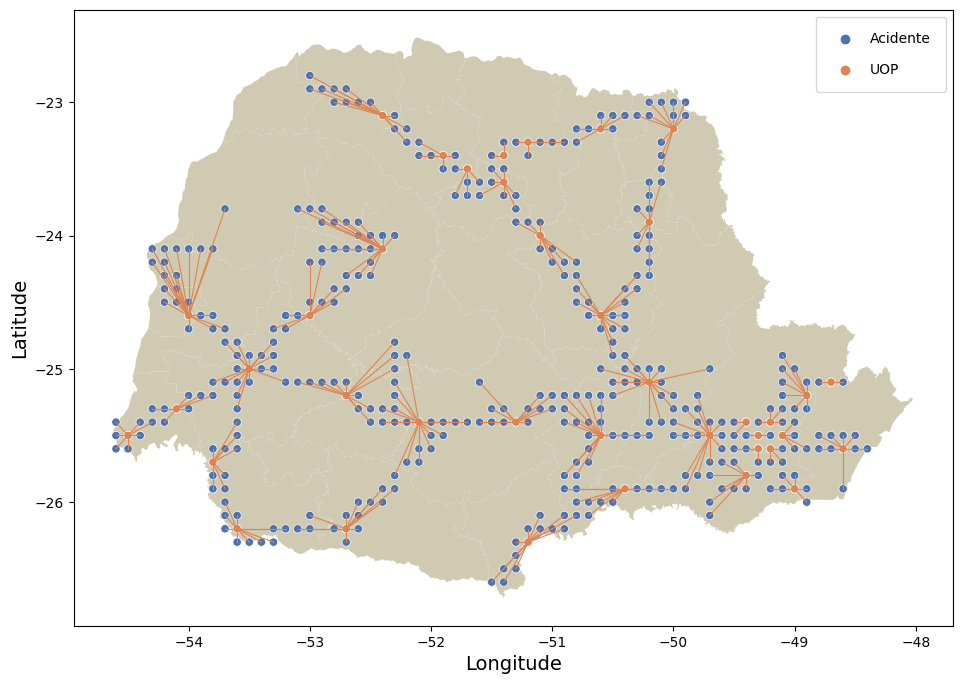

In [21]:
plot_solutions_map(q=15, p=39)

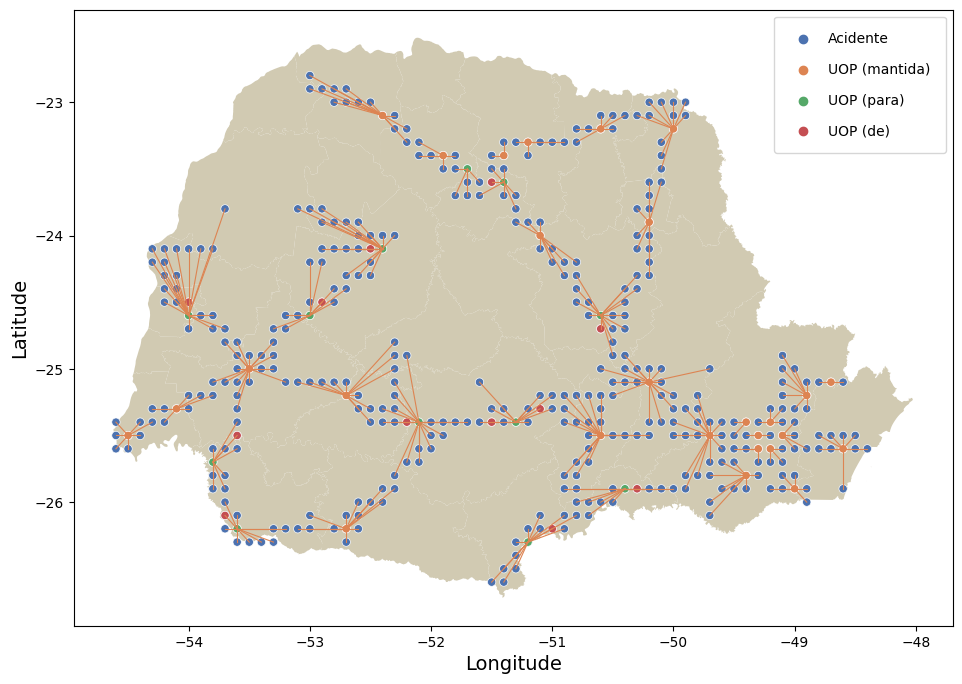

In [31]:
x='longitude'
y='latitude'
xlab="Longitude"
ylab="Latitude"
figsize=(15,8)
fontsize=14

df_sol = get_solution_details(q=15, p=39)
df_sol_old = get_solution_details(q=0, p=39)

df_accidents = df_sol.dropna()
df_accidents['Quadrante'] = "Acidente"

df_uops = df_sol[df_sol['is_median'] == True].copy()
df_uops_old = df_sol_old[df_sol_old['is_median'] == True].copy()

df_uops_fixa = df_uops[df_uops['name'].isin(df_uops_old['name'])].copy()
df_uops_fixa['Quadrante'] = "UOP (mantida)"

df_uops_para = df_uops[~df_uops['name'].isin(df_uops_old['name'])].copy()
df_uops_para['Quadrante'] = "UOP (para)"

df_uops_de = df_uops_old[~df_uops_old['name'].isin(df_uops['name'])].copy()
df_uops_de['Quadrante'] = "UOP (de)"

cols = ["name", "municipality", "n_accidents", "latitude", "longitude", "median_lat", "median_lon", "Quadrante"]
df = pd.concat([df_accidents[cols], df_uops_fixa[cols], df_uops_para[cols], df_uops_de[cols]], ignore_index=True)
df.rename(columns={'n_accidents': "Qtd. acidentes"}, inplace=True)

fig, ax = plt.subplots(figsize=figsize)
SHAPE.plot(ax = ax, color = MAP_COLOR)
p = sns.scatterplot(data=df, x=x, y=y, hue="Quadrante")
p.set_xlabel(xlab, fontsize=fontsize)
p.set_ylabel(ylab, fontsize=fontsize)

legend_name="" 
plt.legend(title=legend_name, title_fontsize=11, labelspacing=1.2, borderpad=1.1)

for row in df.itertuples():
    lat0 = row.latitude
    lat1 = row.median_lat
    lon0 = row.longitude
    lon1 = row.median_lon
    x = (lon0, lon1)
    y = (lat0, lat1)
    plt.plot(x, y, color=PALETTE[1], linewidth='0.8')

plt.savefig('foo.png')   
plt.show()

In [ ]:
def plot_solutions_map2(q, p, x='longitude', y='latitude', xlab="Longitude", ylab="Latitude", figsize=(15,8), fontsize=14):
    df_sol = get_solution_details(q=q, p=p)

    df_accidents = df_sol.dropna()
    df_accidents['Quadrante'] = "Acidente"

    df_uops = df_sol[df_sol['is_median'] == True].copy()
    df_uops['Quadrante'] = "UOP"

    cols = ["name", "municipality", "n_accidents", "latitude", "longitude", "median_lat", "median_lon", "Quadrante"]
    df = pd.concat([df_accidents[cols], df_uops[cols]], ignore_index=True)
    df.rename(columns={'n_accidents': "Qtd. acidentes"}, inplace=True)

    fig, ax = plt.subplots(figsize=figsize)
    SHAPE.plot(ax = ax, color = MAP_COLOR)
    p = sns.scatterplot(data=df, x=x, y=y, hue="Quadrante")
    p.set_xlabel(xlab, fontsize=fontsize)
    p.set_ylabel(ylab, fontsize=fontsize)

    legend_name="" 
    plt.legend(title=legend_name, title_fontsize=11, labelspacing=1.2, borderpad=1.1)

    for row in df.itertuples():
        lat0 = row.latitude
        lat1 = row.median_lat
        lon0 = row.longitude
        lon1 = row.median_lon
        x = (lon0, lon1)
        y = (lat0, lat1)
        plt.plot(x, y, color=PALETTE[1], linewidth='0.8')

    plt.savefig('foo.png')   
    plt.show()

In [ ]:
def get_nearest_uop(df_uops_sol1, df_uops_sol2):

    dist_matrix = get_distance_matrix(
        lat_rows=df_uops_sol1['latitude'],
        lon_rows=df_uops_sol1['longitude'],
        lat_cols=df_uops_sol2['latitude'],
        lon_cols=df_uops_sol2['longitude'],)

    lst_idx = []
    lst_dist = []
    idx_to_ignore = []
    for i in range(0, len(dist_matrix)):
        row = dist_matrix[i]
        min_dist = 999999999999
        min_index = 999999999999
        for j in range(0, len(row)):
            if i != j and j not in idx_to_ignore:
                if row[j] < min_dist:
                    min_dist = row[j]
                    min_index = list(row).index(row[j])
        lst_idx.append(min_index)
        lst_dist.append(min_dist)
        idx_to_ignore.append(min_index)

    df_dists = pd.DataFrame({'idx_j': lst_idx, 'dist': lst_dist})
    df_dists['uop_i'] = [df_uops_sol1.iloc[u]['name'] for u in df_dists.index]
    df_dists['uop_j'] = [df_uops_sol2.iloc[u]['name'] for u in df_dists['idx_j'] if u < 999999]
    df_dists = df_dists.sort_values(by='dist').reset_index(drop=True)
    df_dists['cum_count'] = df_dists.groupby(['uop_j']).cumcount()+1

    return df_dists

In [ ]:
uops_livre = df_livre[df_livre['is_median'] == True]['name']
df_uops_livre = df_quadrants[df_quadrants['name'].isin(uops_livre)].copy()

uops_restrita = df_restrita[df_restrita['is_median'] == True]['name']
df_uops_restrita = df_quadrants[df_quadrants['name'].isin(uops_restrita)].copy()

In [ ]:
df_dists = get_nearest_uop(df_uops_livre, df_uops_restrita)
df_dists

In [ ]:
df_match = df_dists[df_dists['cum_count'] == 1].copy()
df_not_match = df_dists[df_dists['cum_count'] != 1]
df_not_match


In [ ]:
uops_restrita_match = df_match['uop_j']
uops_restrita_not_match = df_restrita[~df_restrita['name'].isin(uops_restrita_match)]['name']
uops_restrita_not_match

In [ ]:
uops_livre_not_match = df_not_match['uop_i']
uops_livre_not_match

In [ ]:
# ORTIGUEIRA 08 -> ORTIGUEIRA 08 (0)
# MANDIRITUBA 02 -> MANDIRITUBA 02 (0)
# LONDRINA 02 -> LONDRINA 02 (0)
# PRUDENTOPOLIS 02 -> UOP01-DEL09-PR (???)

In [ ]:
df_uops_sol1 = df_quadrants[df_quadrants['name'].isin(['PRUDENTOPOLIS 02'])].copy()
df_uops_sol2 = df_quadrants[df_quadrants['name'].isin(['UOP01-DEL09-PR'])].copy()

In [ ]:
dist_matrix = get_distance_matrix(
    lat_rows=df_uops_sol1['latitude'],
    lon_rows=df_uops_sol1['longitude'],
    lat_cols=df_uops_sol2['latitude'],
    lon_cols=df_uops_sol2['longitude'],)

In [ ]:
dist_matrix

In [ ]:
# PRUDENTOPOLIS 02 -> UOP01-DEL09-PR (209.1686)

In [ ]:
df_match = df_match[['dist', 'uop_i', 'uop_j']].copy()
df_manual1 = pd.DataFrame({
    'dist': [0,0,0, 209.1686], 
    'uop_i': ['ORTIGUEIRA 08', 'MANDIRITUBA 02', 'LONDRINA 02', 'PRUDENTOPOLIS 02'], 
    'uop_j': ['ORTIGUEIRA 08', 'MANDIRITUBA 02', 'LONDRINA 02', 'UOP01-DEL09-PR']})

In [ ]:
import plotly.express as px

def plot_interactive_map(df_shape, df_points, bg_color="#e8e4e3", map_hover='NM_RGI', width=1000, height=1000):
    fig = px.choropleth(
        df_shape, 
        geojson=df_shape.geometry, 
        locations=df_shape.index, 
        # color="SIGLA_UF", 
        # color_discrete_map={'PR': "#e8e4e3"},
        color_discrete_sequence=[bg_color],
        hover_name=map_hover, width=width, height=height)
    fig.update_geos(fitbounds="locations", visible=True)
    fig2 = px.scatter_geo(
        data_frame=df_points, 
        lon='longitude', 
        lat='latitude', 
        hover_name='name', color_discrete_sequence=["red"])
    fig.add_trace(fig2.data[0])
    fig.show()

In [ ]:
# plot_interactive_map(df_shape=SHAPE, df_points=df_sol_irrestrita[df_sol_irrestrita['is_median'] == True])

In [ ]:
# plot_interactive_map(df_shape=SHAPE, df_points=df_sol_restrita[df_sol_restrita['is_median'] == True])

In [ ]:
# region = 'immediate_region'

# df_agg_irrestrita = df_sol_irrestrita.groupby([region]).agg(fo_irr=('obj_function', 'sum')).reset_index()
# df_agg_restrita = df_sol_restrita.groupby([region]).agg(fo_res=('obj_function', 'sum')).reset_index()
# df_agg = df_agg_irrestrita.merge(df_agg_restrita, how='left', on=region)
# df_agg['pct_change'] = round((df_agg['fo_res'] - df_agg['fo_irr'])/df_agg['fo_irr'] * 100,2)
# df_agg.sort_values(by='pct_change').reset_index()


In [ ]:
medians_restr = df_sol_restrita['median_name'].unique()
medians_irrestr = df_sol_irrestrita['median_name'].unique()

df_uops_restrita = df_quadrants[(df_quadrants['name'].isin(medians_restr)) & (df_quadrants['is_uop'] == True)].copy()
df_uops_irrestrita = df_quadrants[df_quadrants['name'].isin(medians_irrestr)].copy()

In [ ]:
def compare_nearest_uops(df_uops_irrestrita, df_uops_restrita, repeat=True):
    
    dist_matrix = get_distance_matrix(
        lat_rows=df_uops_irrestrita['latitude'],
        lon_rows=df_uops_irrestrita['longitude'],
        lat_cols=df_uops_restrita['latitude'],
        lon_cols=df_uops_restrita['longitude'],)

    lst_idx = []
    lst_dist = []
    idx_to_ignore = []
    for i in range(0, len(dist_matrix)):
        row = dist_matrix[i]
        min_dist = 999999999999
        min_index = 999999999999
        for j in range(0, len(row)):
            if i != j and j not in idx_to_ignore:
                if row[j] < min_dist:
                    min_dist = row[j]
                    min_index = list(row).index(row[j])
        lst_idx.append(min_index)
        lst_dist.append(min_dist)
        if not repeat:
            idx_to_ignore.append(min_index)

    df_dists = pd.DataFrame({'idx_restrita': lst_idx, 'dist': lst_dist})
    df_dists['uop_irrestrita'] = [df_uops_irrestrita.iloc[u]['name'] for u in df_dists.index]
    df_dists['uop_restrita'] = [df_uops_restrita.iloc[u]['name'] for u in df_dists['idx_restrita'] if u < 999999]
    df_dists = df_dists.sort_values(by='dist').reset_index(drop=True)
    df_dists['cum_count'] = df_dists.groupby(['uop_restrita']).cumcount()+1

    return df_dists

In [ ]:
df_dists = compare_nearest_uops(df_uops_irrestrita, df_uops_restrita, repeat=True)
df_dists

In [ ]:
# Carrega os resultados:
df_all_results = get_all_results()

In [ ]:
# Soluções livres
df_results_p39 = get_df_results(df_all_results, p=39)
df_results_p39['obj_function_abs_pct_change'] = df_results_p39['obj_function_abs_pct_change'].fillna(0)
df_results_p39

In [ ]:
plot_fo(df_results_p39, x_param="q", xtick_min=0, xtick_max=33, invert_x=True, pct_cutover=1)

In [ ]:
df_sol_p39_q15 = get_solution_details(p=39, q=15)
fo_p39_q15 = df_sol_p39_q15['obj_function'].sum()
fo_p39_q15

In [ ]:
fo_irrestrita

In [ ]:
fo_restrita

In [ ]:
(fo_p39_q15 - fo_irrestrita)/fo_irrestrita * 100